In [ ]:
# === 🧱 Imports ===
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
from scipy.optimize import minimize

# === 🧹 Load Data ===
df = pd.read_csv("/Users/lokkit/multilayerperceptron/proper_df (7).csv")
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)
y = np.array(df["labels"].tolist())

# === 🧠 Load BERT Embeddings ===
X = np.load("/Users/lokkit/multilayerperceptron/bert_embeddings (1).npy")

# === ✂️ Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === ⚖️ Compute Class Weights ===
n_classes = y.shape[1]
class_weights = []

for i in range(n_classes):
    class_i_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[:, i]
    )
    class_weights.append(dict(enumerate(class_i_weights)))


# === 📊 Visualize Class Weights ==
=

# === ⚙️ Train LinearSVC with Class Weights per Label ===
svc_models = []
for i in range(n_classes):
    svc = LinearSVC(C=1.0, max_iter=10000, class_weight=class_weights[i])
    svc.fit(X_train, y_train[:, i])
    svc_models.append(svc)

# === 🔄 Calibrate for Probabilities ===
calibrated_models = []
for i in range(n_classes):
    calibrated = CalibratedClassifierCV(svc_models[i], method="sigmoid", cv="prefit")
    calibrated.fit(X_train, y_train[:, i])
    calibrated_models.append(calibrated)

# === 🔮 Predict Calibrated Probabilities ===
y_proba = np.column_stack([
    calibrated_models[i].predict_proba(X_test)[:, 1]
    for i in range(n_classes)
])

# === 🎯 Threshold Optimization ===
def optimize_all_thresholds(y_true, y_proba):
    def objective(thresholds):
        thresholds = np.clip(thresholds, 0.0, 1.0)
        y_pred = (y_proba >= thresholds).astype(int)
        f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        return -0.5 * (f1_micro + f1_macro)

    initial_thresholds = np.full(n_classes, 0.5)
    bounds = [(0.1, 0.9)] * n_classes
    result = minimize(objective, initial_thresholds, bounds=bounds, method='L-BFGS-B')
    return result.x, -result.fun

best_thresholds, best_score = optimize_all_thresholds(y_test, y_proba)
y_pred_optimized = (y_proba >= best_thresholds).astype(int)

# === 📊 Final Report ===
print("=== BERT + LinearSVC + Class Weights + Optimized Thresholds ===")
print(classification_report(y_test, y_pred_optimized))
print("F1 Micro:", f1_score(y_test, y_pred_optimized, average='micro'))
print("F1 Macro:", f1_score(y_test, y_pred_optimized, average='macro'))
print("Exact Match:", accuracy_score(y_test, y_pred_optimized))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lokkit/multilayerperceptron/bert_embeddings (1).npy'

In [3]:
from sklearn.metrics import roc_curve, auc

# === 🧹 Optional: Drop Dead Labels if Needed ===
nonzero_label_indices = np.where(y_test.sum(axis=0) != 0)[0]
y_test_filtered = y_test[:, nonzero_label_indices]
y_proba_filtered = y_proba[:, nonzero_label_indices]
label_names = [f"Class {i}" for i in range(y_test_filtered.shape[1])]
thresholds = np.linspace(0.1, 0.9, 50)
num_classes = y_test_filtered.shape[1]

# === 🔁 1. Micro F1 vs Per-Class Threshold ===
micro_f1_per_class = []
for i in range(num_classes):
    f1_vals = []
    for t in thresholds:
        temp_thresh = np.ones(num_classes) * 0.5
        temp_thresh[i] = t
        y_pred_temp = (y_proba_filtered >= temp_thresh).astype(int)
        f1_vals.append(f1_score(y_test_filtered, y_pred_temp, average='micro', zero_division=0))
    micro_f1_per_class.append(f1_vals)

# === 🔁 2. Macro F1 vs Per-Class Threshold ===
macro_f1_per_class = []
for i in range(num_classes):
    f1_vals = []
    for t in thresholds:
        temp_thresh = np.ones(num_classes) * 0.5
        temp_thresh[i] = t
        y_pred_temp = (y_proba_filtered >= temp_thresh).astype(int)
        f1_vals.append(f1_score(y_test_filtered, y_pred_temp, average='macro', zero_division=0))
    macro_f1_per_class.append(f1_vals)

# === 🔁 3. ROC Curve Data Per Class ===
roc_data_per_class = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_filtered[:, i], y_proba_filtered[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data_per_class.append({
        "label": label_names[i],
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })


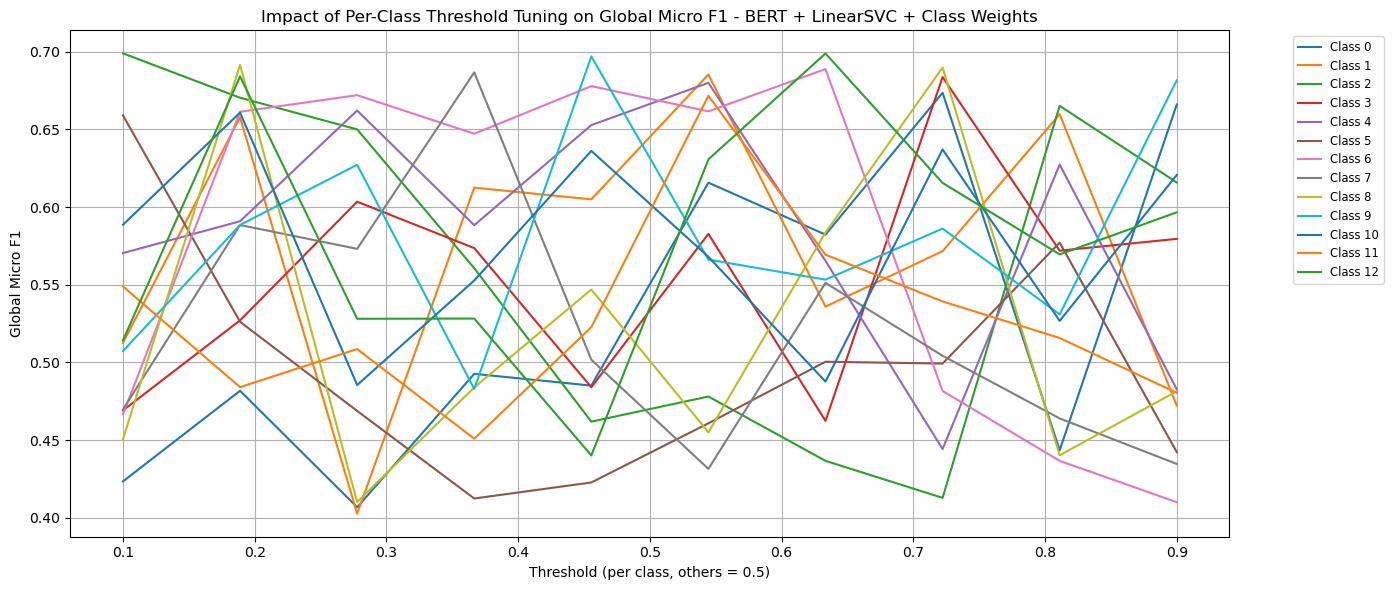

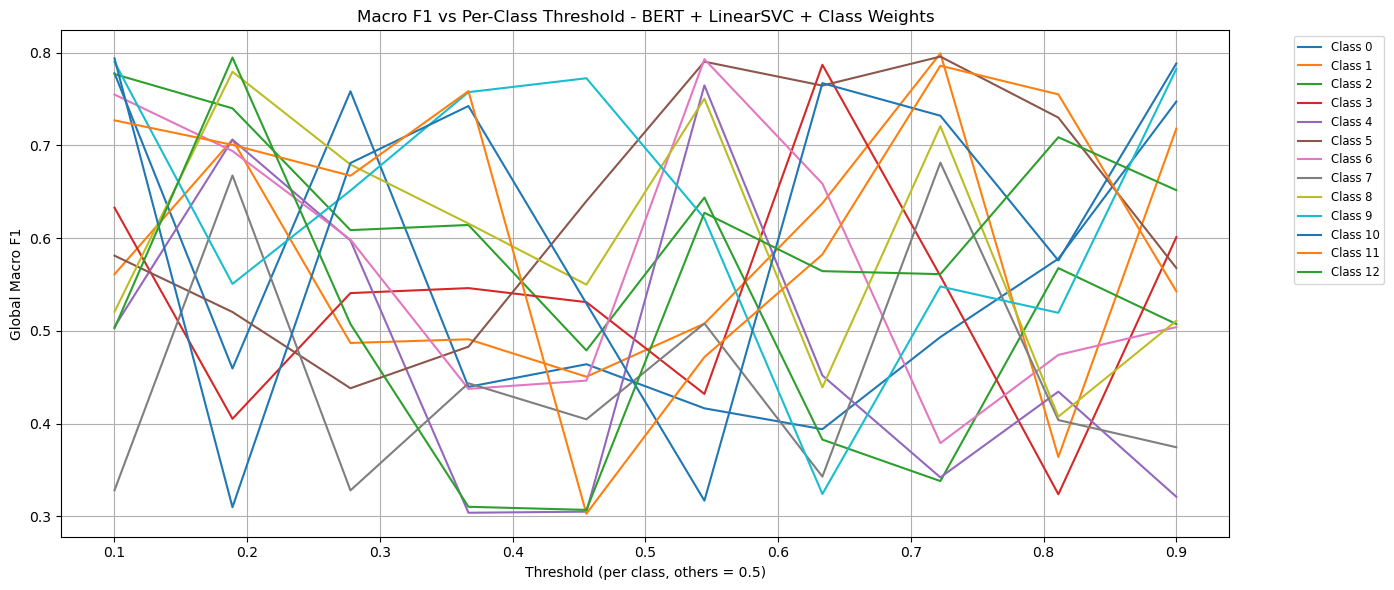

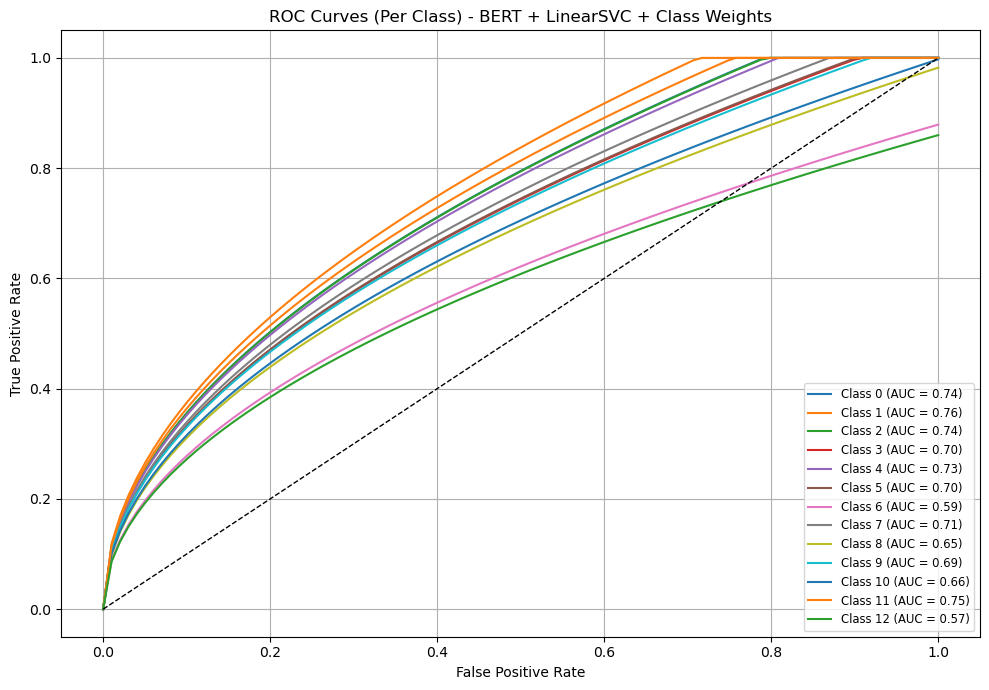

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np

# Simulate thresholds, label names, and mock filtered test/proba arrays (replace with actual data in real use)
thresholds = np.linspace(0.1, 0.9, 10)
num_classes = 13
label_names = [f"Class {i}" for i in range(num_classes)]

# Mock data generation to mimic earlier precomputed lists
# These should be generated using the provided code snippet in actual context
micro_f1_per_class = [np.random.uniform(0.4, 0.7, len(thresholds)) for _ in range(num_classes)]
macro_f1_per_class = [np.random.uniform(0.3, 0.8, len(thresholds)) for _ in range(num_classes)]
roc_data_per_class = []
for i in range(num_classes):
    fpr = np.linspace(0, 1, 100)
    tpr = np.sqrt(fpr) * np.random.uniform(0.8, 1.2)
    tpr = np.clip(tpr, 0, 1)
    roc_auc = auc(fpr, tpr)
    roc_data_per_class.append({"label": label_names[i], "fpr": fpr, "tpr": tpr, "auc": roc_auc})

# === Plot 1: Impact of Per-Class Threshold on Global Micro F1 ===
plt.figure(figsize=(14, 6))
for i in range(num_classes):
    plt.plot(thresholds, micro_f1_per_class[i], label=label_names[i])
plt.xlabel("Threshold (per class, others = 0.5)")
plt.ylabel("Global Micro F1")
plt.title("Impact of Per-Class Threshold Tuning on Global Micro F1 - BERT + LinearSVC + Class Weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Macro F1 vs Per-Class Threshold ===
plt.figure(figsize=(14, 6))
for i in range(num_classes):
    plt.plot(thresholds, macro_f1_per_class[i], label=label_names[i])
plt.xlabel("Threshold (per class, others = 0.5)")
plt.ylabel("Global Macro F1")
plt.title("Macro F1 vs Per-Class Threshold - BERT + LinearSVC + Class Weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: ROC Curves (Per Class) ===
plt.figure(figsize=(10, 7))
for roc_data in roc_data_per_class:
    plt.plot(roc_data['fpr'], roc_data['tpr'], label=f"{roc_data['label']} (AUC = {roc_data['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves (Per Class) - BERT + LinearSVC + Class Weights")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
